<a href="https://colab.research.google.com/github/jameswang287/Car-Detection/blob/master/car_detection_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Car Make and Model Detection**
James Wang

README: https://people.ucsc.edu/~jwang402/car_det

PyTorch

Note: Run all cells in order in Google Colab for functionality.
Only tested on **Google Colab** with **GPU runtime**.

Requires NVIDIA CUDA Support

**Import all necessary packages:**

In [1]:
import tarfile
import os
import csv
import time
import torch
import json
from random import randint
from pathlib import Path
from PIL import Image
import PIL.Image
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from matplotlib.ticker import FormatStrFormatter
from google.colab.patches import cv2_imshow
import matplotlib.image as mpimg 
from matplotlib.pyplot import imshow
from IPython.display import Image
%matplotlib inline


**Download and extract files from Stanford University Repo**


In [2]:
#Download full training data (~935 MB)
!wget --no-check-certificate \
    http://imagenet.stanford.edu/internal/car196/cars_train.tgz \
    -O /tmp/cars_train.tgz #downloaded directory
#extract training data to /tmp/train/
train_tar = tarfile.open('/tmp/cars_train.tgz')
train_tar.extractall('/tmp/train') # specify which folder to extract to
train_tar.close()
#directory looks like /tmp/train/cars_train/


--2020-06-30 17:12:44--  http://imagenet.stanford.edu/internal/car196/cars_train.tgz
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 979269282 (934M) [application/x-gzip]
Saving to: ‘/tmp/cars_train.tgz’

/tmp/cars_train.tgz 100%[===================>] 933.90M  17.1MB/s    in 2m 3s   

2020-06-30 17:14:47 (7.61 MB/s) - ‘/tmp/cars_train.tgz’ saved [979269282/979269282]



In [3]:
#Download full testing data (~933MB)
!wget --no-check-certificate \
    http://imagenet.stanford.edu/internal/car196/cars_test.tgz \
    -O /tmp/cars_test.tgz #downloaded directory
#extract testing data to tmp/test/
test_tar = tarfile.open('/tmp/cars_test.tgz')
test_tar.extractall('/tmp/test') # specify which folder to extract to
test_tar.close()
#directory looks like /tmp/test/cars_test/


--2020-06-30 17:14:57--  http://imagenet.stanford.edu/internal/car196/cars_test.tgz
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977350468 (932M) [application/x-gzip]
Saving to: ‘/tmp/cars_test.tgz’

/tmp/cars_test.tgz  100%[===================>] 932.07M  24.0MB/s    in 82s     

2020-06-30 17:16:19 (11.4 MB/s) - ‘/tmp/cars_test.tgz’ saved [977350468/977350468]



In [4]:
#Download labels (~0.3MB)
!wget --no-check-certificate \
    http://ai.stanford.edu/~jkrause/cars/car_devkit.tgz \
    -O /tmp/car_devkit.tgz
Path("/tmp/annos").mkdir(parents=True, exist_ok=True)
!wget --no-check-certificate \
    https://people.ucsc.edu/~jwang402/carslabel/anno_test.csv \
    -O /tmp/annos/anno_test.csv
#extract labels to /tmp/labels/
label_tar = tarfile.open('/tmp/car_devkit.tgz')
label_tar.extractall('/tmp/labels') # specify which folder to extract to
label_tar.close()
#directory looks like /tmp/labels/devkit/
#devkit dir contains: cars_meta.mat, cars_test_annos.mat, 
#cars_train_annos.mat, eval_train.m, README, train_perfect_preds.txt


--2020-06-30 17:16:30--  http://ai.stanford.edu/~jkrause/cars/car_devkit.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330960 (323K) [application/x-gzip]
Saving to: ‘/tmp/car_devkit.tgz’

/tmp/car_devkit.tgz 100%[===================>] 323.20K  --.-KB/s    in 0.1s    

2020-06-30 17:16:30 (2.22 MB/s) - ‘/tmp/car_devkit.tgz’ saved [330960/330960]

--2020-06-30 17:16:31--  https://people.ucsc.edu/~jwang402/carslabel/anno_test.csv
Resolving people.ucsc.edu (people.ucsc.edu)... 128.114.119.88
Connecting to people.ucsc.edu (people.ucsc.edu)|128.114.119.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 225299 (220K) [text/csv]
Saving to: ‘/tmp/annos/anno_test.csv’

/tmp/annos/anno_tes 100%[===================>] 220.02K  --.-KB/s    in 0.1s    

2020-06-30 17:16:31 (2.06 MB/s) - ‘/tmp/annos/anno_test.csv’ saved [22529

**Load Class Mapping**

In [5]:
#Classes are assigned numerical value of 1-196, each
#mapping to a string. Data from cars_meta matlab file
#This applies to all data.
meta = loadmat('/tmp/labels/devkit/cars_meta.mat')
meta.keys()
type(meta['class_names']),meta['class_names'].shape
[item.flat[0] for item in meta['class_names'][0][0]]
classes = [[row.flat[0] for row in line] for line in meta['class_names'][0]]
classDict = {}
classCount = 1
for c in classes:
    classDict.update({classCount:c[0]})
    classCount = classCount + 1
term = 0
for num, model in classDict.items():
    print('Class #', num,'Model String:', model)
    term = term + 1
    if term == 4:
        break
print('...')


Class # 1 Model String: AM General Hummer SUV 2000
Class # 2 Model String: Acura RL Sedan 2012
Class # 3 Model String: Acura TL Sedan 2012
Class # 4 Model String: Acura TL Type-S 2008
...


**Load labels**

In [6]:
#LABELS FOR TRAINING DATA
#contains bbox, class, and filename
labelfile = loadmat('/tmp/labels/devkit/cars_train_annos.mat')
labelfile.keys()
type(labelfile['annotations']),labelfile['annotations'].shape
type(labelfile['annotations'][0][0]),labelfile['annotations'][0][0].shape
labelfile['annotations'][0][0]['bbox_x1'], labelfile['annotations'][0][0]['fname']
[item.flat[0] for item in labelfile['annotations'][0][0]]
"""
The following variable 'trainLabels' contains a list of labels for 
every test image the format of each element is as follows:
### bbox_x1, bbox_y1, bbox_x2, bbox_y2, class, filename
"""
trainLabels = [[row.flat[0] for row in line] for line in labelfile['annotations'][0]]
#Outputting the table for readibility with pandas
columns = ['boundingbox_x1', 'boundingbox_y1', 'boundingbox_x2', 'boundingbox_y2', 'class', 'fname']
view = pd.DataFrame(trainLabels, columns=columns)
view.head()


,boundingbox_x1,boundingbox_y1,boundingbox_x2,boundingbox_y2,class,fname
0,39,116,569,375,14,00001.jpg
1,36,116,868,587,3,00002.jpg
2,85,109,601,381,91,00003.jpg
3,621,393,1484,1096,134,00004.jpg
4,14,36,133,99,106,00005.jpg


In [7]:
#LABELS FOR TESTING DATA
#Contains bbox and filename
lf = loadmat('/tmp/labels/devkit/cars_test_annos.mat')
lf.keys()
type(lf['annotations']),lf['annotations'].shape
type(lf['annotations'][0][0]),lf['annotations'][0][0].shape
lf['annotations'][0][0]['bbox_x1'], lf['annotations'][0][0]['fname']
[item.flat[0] for item in lf['annotations'][0][0]]
"""
The following variable 'testLabels' contains a list of labels for 
every test image the format of each element is as follows:
### bbox_x1, bbox_y1, bbox_x2, bbox_y2, filename
there is no class name in this set of labels
"""
testLabels = [[row.flat[0] for row in line] for line in lf['annotations'][0]]

#Test labels class and fname
with open('/tmp/annos/anno_test.csv') as csv_file:
    read = csv.reader(csv_file, delimiter=',')
    testDict = {}
    classCount = 1
    for row in read:
        testDict.update({row[0]:row[5]})
        classCount = classCount + 1
    print(len(testDict), 'processed')


8041 processed


In [8]:
#What labels look like for Training vs Testing after processing
print("Train Labels")
print("...")
for i in range(len(trainLabels) - 4, len(trainLabels)):
    print(trainLabels[i])
print("\nTest Labels")
print("...")
for i in range(len(testLabels) - 4, len(testLabels)):
    print(testLabels[i])


Train Labels
...
[138, 150, 706, 523, 196, '08141.jpg']
[26, 246, 660, 449, 163, '08142.jpg']
[78, 526, 1489, 908, 112, '08143.jpg']
[20, 240, 862, 677, 17, '08144.jpg']

Test Labels
...
[23, 18, 640, 459, '08038.jpg']
[33, 27, 602, 252, '08039.jpg']
[33, 142, 521, 376, '08040.jpg']
[77, 73, 506, 380, '08041.jpg']


**Preprocess Images**

In [9]:
"""
Preprocess Training Images
Gets all training images and crops by bounding box, saves to a new directory
The directory housing training image has subdirectories named by class name
with each corresponding image in the corresponding folder
Saves ~7% of images for validation
"""
print(len(trainLabels), "images to process.")
Path("/tmp/processedTrain").mkdir(parents=True, exist_ok=True)
Path("/tmp/processedValidation").mkdir(parents=True, exist_ok=True)
count = 1
for l in trainLabels:
    print('Processing image', count, 'of', len(trainLabels))
    #bbox
    x1 = l[0]
    y1 = l[1]
    x2 = l[2]
    y2 = l[3]
    class_num = l[4]
    filename = l[5]
    address = "/tmp/train/cars_train/" + filename
    classAppend = classDict.get(class_num) + '/'
    if count < 7000:
        saveDir = "/tmp/processedTrain/" + classAppend
    else:
        saveDir = "/tmp/processedValidation/" + classAppend
    im = PIL.Image.open(address)
    region = im.crop((x1, y1, x2, y2))
    Path(saveDir).mkdir(parents=True, exist_ok=True)
    saveAddress = saveDir + filename
    region.save(saveAddress)    
    print('Saved', saveAddress)
    count = count + 1
print("------------------------")
print("Training images preprocessing complete.")

Streaming output truncated to the last 5000 lines.
Saved /tmp/processedTrain/Chevrolet HHR SS 2010/05646.jpg
Processing image 5647 of 8144
Saved /tmp/processedTrain/Audi TT RS Coupe 2012/05647.jpg
Processing image 5648 of 8144
Saved /tmp/processedTrain/Bentley Arnage Sedan 2009/05648.jpg
Processing image 5649 of 8144
Saved /tmp/processedTrain/Ford F-150 Regular Cab 2007/05649.jpg
Processing image 5650 of 8144
Saved /tmp/processedTrain/BMW 3 Series Sedan 2012/05650.jpg
Processing image 5651 of 8144
Saved /tmp/processedTrain/Fisker Karma Sedan 2012/05651.jpg
Processing image 5652 of 8144
Saved /tmp/processedTrain/MINI Cooper Roadster Convertible 2012/05652.jpg
Processing image 5653 of 8144
Saved /tmp/processedTrain/Dodge Dakota Crew Cab 2010/05653.jpg
Processing image 5654 of 8144
Saved /tmp/processedTrain/BMW 1 Series Coupe 2012/05654.jpg
Processing image 5655 of 8144
Saved /tmp/processedTrain/Ford Freestar Minivan 2007/05655.jpg
Processing image 5656 of 8144
Saved /tmp/processedTrain/F

In [10]:
"""
Preprocess Testing Images
Gets all training images and crops by bounding box, saves to a new directory
"""
print(len(testLabels), "images to process.")
Path("/tmp/processedTest").mkdir(parents=True, exist_ok=True)
Path("/tmp/boundedTest").mkdir(parents=True, exist_ok=True)
count = 1
for l in testLabels:
    print('Processing image', count, 'of', len(testLabels))
    x1 = l[0]
    y1 = l[1]
    x2 = l[2]
    y2 = l[3]
    filename = l[4]
    c_num = testDict.get(filename)
    classAppend = classDict.get(int(c_num)) + '/'
    address = "/tmp/test/cars_test/" + filename
    saveDir = "/tmp/processedTest/" + classAppend
    im = PIL.Image.open(address)
    region = im.crop((x1, y1, x2, y2))
    Path(saveDir).mkdir(parents=True, exist_ok=True)
    saveAddress = saveDir + filename
    saveAddress2 = "/tmp/boundedTest/" + filename
    region.save(saveAddress2)    
    print('Saved', saveAddress2)
    region.save(saveAddress)    
    print('Saved', saveAddress)
    count = count + 1
print("------------------------")
print("Testing images preprocessing complete.")


Streaming output truncated to the last 5000 lines.
Saved /tmp/boundedTest/06376.jpg
Saved /tmp/processedTest/Rolls-Royce Phantom Sedan 2012/06376.jpg
Processing image 6377 of 8041
Saved /tmp/boundedTest/06377.jpg
Saved /tmp/processedTest/Dodge Charger SRT-8 2009/06377.jpg
Processing image 6378 of 8041
Saved /tmp/boundedTest/06378.jpg
Saved /tmp/processedTest/Dodge Caravan Minivan 1997/06378.jpg
Processing image 6379 of 8041
Saved /tmp/boundedTest/06379.jpg
Saved /tmp/processedTest/Audi TT RS Coupe 2012/06379.jpg
Processing image 6380 of 8041
Saved /tmp/boundedTest/06380.jpg
Saved /tmp/processedTest/Nissan 240SX Coupe 1998/06380.jpg
Processing image 6381 of 8041
Saved /tmp/boundedTest/06381.jpg
Saved /tmp/processedTest/Hyundai Sonata Sedan 2012/06381.jpg
Processing image 6382 of 8041
Saved /tmp/boundedTest/06382.jpg
Saved /tmp/processedTest/Bentley Arnage Sedan 2009/06382.jpg
Processing image 6383 of 8041
Saved /tmp/boundedTest/06383.jpg
Saved /tmp/processedTest/Bentley Continental Flyi

**Data is now saved as follows:**

variables: trainLabel, testLabel (all have to be cropped)

preprocessed data directories:

training data: /tmp/processedTrain/Chevrolet Corvette Convertible 2012/06923.jpg

validation data: /tmp/processedValidation/GMC Savana Van 2012/08131.jpg

testing data: /tmp/boundedTest/08040.jpg






**Preprocessed Image Demo**

02732.jpg


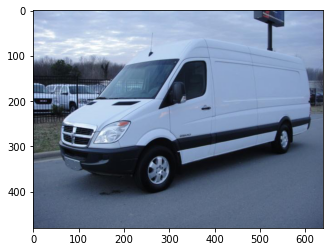

In [26]:
#ORIGINAL TRAIN IMAGE, randomly selected
rand = str(randint(1, len(trainLabels)-2000)).zfill(5)
fname = rand + ".jpg"
print(fname)
f = '/tmp/train/cars_train/' + fname
im1_before = mpimg.imread(f)
imshow(im1_before)


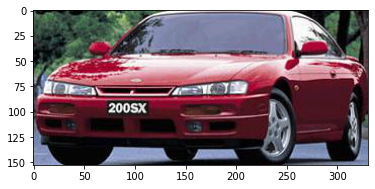

In [12]:
#PROCESSED TRAIN IMAGE
for l in trainLabels:
    if fname == l[5]:
        c_num = int(l[4])
        clAppend = str(classDict.get(c_num)) + '/'
        app = clAppend + fname
        f2 = '/tmp/processedTrain/' + app
        im1_after = mpimg.imread(f2)
        imshow(im1_after)
        break


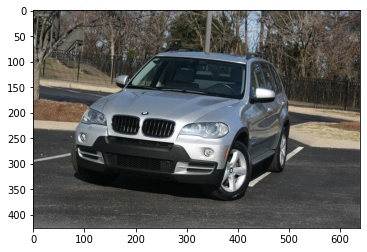

In [13]:
#ORIGINAL TEST IMAGE 
im1_before = mpimg.imread("/tmp/test/cars_test/08041.jpg")
imshow(im1_before)


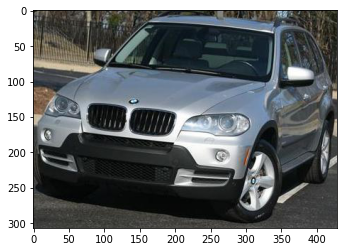

In [14]:
#PROCESSED TEST IMAGE 
im1_before = mpimg.imread("/tmp/boundedTest/08041.jpg")
imshow(im1_before)


**Transform and load**

In [15]:
"""
Prepare dataset for loading into model. First transform images with flips and
rotations for robust model, then create loader with ImageFolder. Images will
be shuffled as well to ensure order doesn't matter.
"""
def getTrainLoad(directory):
    data = datasets.ImageFolder(directory, 
                                transform = transforms.Compose([transforms.Resize((244,244)),
                                transforms.RandomRotation(30),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
    return torch.utils.data.DataLoader(data, batch_size=128, shuffle=True)

def getTestLoad(directory):
    data = datasets.ImageFolder(directory,
                                transform = transforms.Compose([transforms.Resize((244,244)),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
    return torch.utils.data.DataLoader(data, batch_size=32, shuffle=True)
trainLoad = getTrainLoad('/tmp/processedTrain')
validLoad = getTestLoad('/tmp/processedValidation')
testLoad = getTestLoad('/tmp/processedTest/')


**Transfer Learning - Resnet34 Implementation**

**Model Creation**


In [16]:
model = models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 196)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
device = 'cuda'
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**Train**

In [17]:
start = time.time()
epochs = 10
iterations = 0
val = 35
model.to(device)
model.train()

def validation(model, validloader, criterion):
    valid_loss = 0
    accuracy = 0
    model.to(device)
    for i, (images, labels) in enumerate(validloader):
        images, labels = images.to(device), labels.to(device)
        output = model.forward(images)
        valid_loss = valid_loss + criterion(output, labels).item()
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy = accuracy + equality.type(torch.FloatTensor).mean()
    return valid_loss, accuracy

v_loss_hist = list()
tr_loss_hist = list()
v_acc_hist = list()

for e in range(epochs):
    running_loss = 0
    for i, (inputs, labels) in enumerate(trainLoad):
        iterations += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        #validation
        if iterations % val == 0:
            model.eval()
            with torch.no_grad():
                valid_loss, accuracy = validation(model, validLoad, criterion)
            if (e + 1) > len(v_loss_hist):
                v_loss_hist.append(round(valid_loss/len(validLoad),3))
                tr_loss_hist.append(round(running_loss/val,3))
                v_acc_hist.append(round(float(accuracy/len(validLoad)),3))
            print(f"Epoch #  {e+1}, \
            Valid Loss: {round(valid_loss/len(validLoad),5)}, \
            Training Loss: {round(running_loss/val,5)}, \
            Valid Accuracy: {round(float(accuracy/len(validLoad)),5)}")
            model.train()
            lrscheduler.step(accuracy * 100)
end = time.time()
print("Training Complete.")
print("Training time in seconds:", end - start)

Epoch #  1,             Valid Loss: 5.48461,             Training Loss: 5.19237,             Valid Accuracy: 0.01413
Epoch #  2,             Valid Loss: 5.70772,             Training Loss: 1.61535,             Valid Accuracy: 0.02715
Epoch #  2,             Valid Loss: 6.19706,             Training Loss: 4.76152,             Valid Accuracy: 0.03497
Epoch #  3,             Valid Loss: 6.81885,             Training Loss: 1.79407,             Valid Accuracy: 0.05059
Epoch #  4,             Valid Loss: 7.09574,             Training Loss: 0.36015,             Valid Accuracy: 0.06337
Epoch #  4,             Valid Loss: 7.8723,             Training Loss: 1.44385,             Valid Accuracy: 0.05691
Epoch #  5,             Valid Loss: 8.08176,             Training Loss: 0.51801,             Valid Accuracy: 0.06646
Epoch #  6,             Valid Loss: 8.5346,             Training Loss: 0.07356,             Valid Accuracy: 0.06535
Epoch #  6,             Valid Loss: 8.68044,             Training 

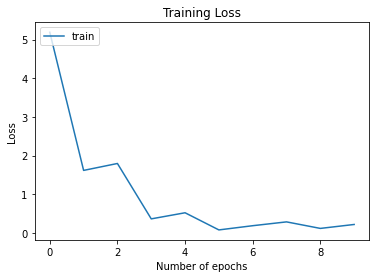

In [18]:
plt.plot(tr_loss_hist)
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['train'], loc='upper left')
plt.show()


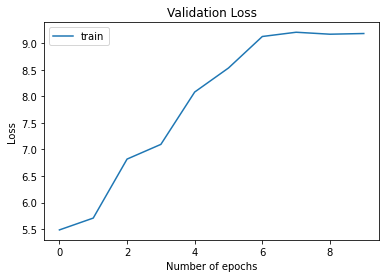

In [19]:
plt.plot(v_loss_hist)
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['train'], loc='upper left')
plt.show()


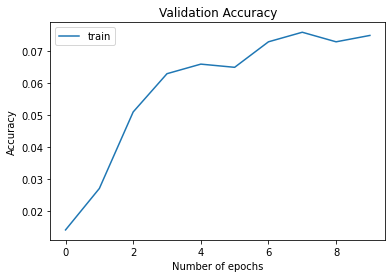

In [20]:
plt.plot(v_acc_hist)
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend(['train'], loc='upper left')
plt.show()


In [21]:
model.to(device)
"""
Tests model accuracy with test images
"""
start = time.time()
total = 0
correct = 0
acc_hist = list()
tot_hist = list()
with torch.no_grad():
    for data in testLoad:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, guess = torch.max(outputs.data, 1) 
        total = total + labels.size(0) #total num of images
        correct = correct + (guess == labels).sum().item() #number correct
        acc_hist.append(correct)
        tot_hist.append(total)
end = time.time()
print("Total images tested in model:", len(testLabels))
print("Total accurate predictions:", correct)
print(f"Accuracy of model w/ full test dataset fed: {round(100 * correct / total,8)}%")
print("Testing time in seconds:", end - start)


Total images tested in model: 8041
Total accurate predictions: 6566
Accuracy of model w/ full test dataset fed: 81.65651038%
Testing time in seconds: 83.73781728744507


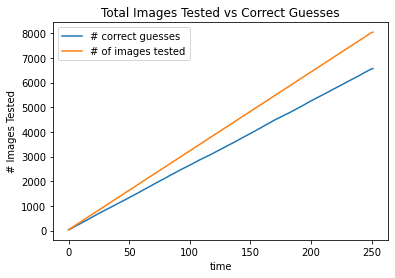

In [22]:
plt.plot(acc_hist)
plt.plot(tot_hist)
plt.title('Total Images Tested vs Correct Guesses')
plt.ylabel('# Images Tested')
plt.xlabel('time')
plt.legend(['# correct guesses', '# of images tested'], loc='upper left')
plt.show()


**Make a CPU copy of the Model for testing**

In [23]:
#make a copy of the model to change from gpu to cpu.
import copy
model_copy = copy.deepcopy(model)
model_copy.to('cpu')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, idx = find_classes("/tmp/processedTest/")

def predict(image, model, topk=5):
    #open image and change to np form//cpu consideration
    pil_in = PIL.Image.open(image)
    transform = transforms.Compose([transforms.Resize((244,244)),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])])
    pilTrans = transform(pil_in)
    img = np.array(pilTrans)
    img_tensor = torch.from_numpy(img).type(torch.FloatTensor) #np to tensor
    dimen = img_tensor.unsqueeze_(0)
    model.eval()
    with torch.no_grad():
        output = model.forward(dimen)
    probs_top = output.topk(topk)[0]
    top_prediction = output.topk(topk)[1]
    p = np.array(top_prediction)[0]
    o_guesses = np.array(top_prediction)[0]
    return p, o_guesses

**Randomly pick a test image to predict**

Randomly chosen file to classify: /tmp/boundedTest/07609.jpg
Seconds elapsed for prediction: 0.16881918907165527
*******************************
FIRST GUESS:  Hyundai Veracruz SUV 2012
*******************************
Might also be: Nissan Leaf Hatchback 2012
Might also be: Chevrolet Traverse SUV 2012
Might also be: Suzuki Aerio Sedan 2007
Might also be: Suzuki SX4 Sedan 2012 



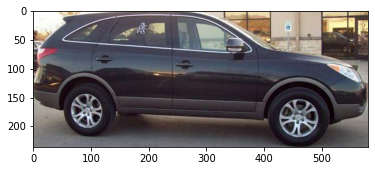

In [28]:
random_test_image = str(str(randint(1, len(testLabels))).zfill(5)) + '.jpg'
image_to_classify = "/tmp/boundedTest/" + random_test_image
device = ('cpu')
start = time.time()
tp, ps = predict(image_to_classify, model_copy, topk=5)
print("Randomly chosen file to classify:",image_to_classify)
end = time.time()
print("Seconds elapsed for prediction:", end - start)
print("*******************************")
print("FIRST GUESS: ",classes[ps[0]])
print("*******************************")
print("Might also be:", classes[ps[1]])
print("Might also be:", classes[ps[2]])
print("Might also be:", classes[ps[3]])
print("Might also be:", classes[ps[4]], "\n")
gimg = mpimg.imread(image_to_classify)
imshow(gimg)
